# Observational snow depth dataset of the Tibetan Plateau (Version 1.0) (1961-2013)
http://data.tpdc.ac.cn/en/data/72d6dadf-8e1c-458b-b24e-91539042dfe6/

The Tibetan Plateau has an average altitude of over 4000 m and is the region with the highest altitude and the largest snow cover in the middle and low latitudes of the Northern Hemisphere regions. Snow cover is the most important underlying surface of the seasonal changes on the Tibetan Plateau and an important composing element of ecological environment. Ice and snow melt water is an important water resource of the plateau and its downstream areas. At the same time, plateau snow, as an important land-surface forcing factor, is closely related to disastrous weather (such as droughts and floods) in East Asia, the South Asian monsoon and in the middle and lower reaches of the Yangtze River. It is an important indicator of short-term climate prediction and one of the most sensitive responses to global climate change. The snow depth refers to the vertical depth from the surface of the snow to the ground. It is an important parameter for snow characteristics and one of the conventional meteorological observation elements. It is the key parameter of snow water equivalent estimation, climate effect studies of snow cover, the basin water balance, the simulation and monitoring of snow-melt, and snow disaster evaluation and grading.

In this data set, the Tibetan Plateau boundary was determined by adopting the natural topography as the leading factor and by comprehensive consideration of the principles of altitude, plateau and mountain integrity. The main part of the plateau is in the Tibetan Autonomous Region and Qinghai Province, with an area of 2.572 million square kilometers, accounting for 26.8% of the total land area of China. The snow depth observation data are the monthly maximum snow depth data after quality detection and quality control. There are 102 meteorological stations in the study area, most of which were built during the 1950s to 1970s. The data for some months or years for sites existing during this period were missing, and the complete observational records from 1961 to 2013 were adopted. The temporal resolution is daily, the spatial coverage is the Tibetan Plateau, and all the data were quality controlled. Accurate and detailed plateau snow depth data are of great significance for the diagnosis of climate change, the evolution of the Asian monsoon and the management of regional snow-melt water resources.

### Used in:
- Evaluation of snow cover and snow depth on the Qinghai–Tibetan Plateau derived from passive microwave remote sensing (Dai et al., [2017](https://tc.copernicus.org/articles/11/1933/2017/))


In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '/home/lalandmi/Dropbox/Thèse/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [2]:
period = slice('1999','2012')
latlim, lonlim = u.get_domain_HMA()
seasons = ['Annual', 'DJFMA', 'JJAS']

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

## Load topo

In [3]:
ds = xr.open_dataset('~/data/GMTED2010/GMTED2010_15n060_0250deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

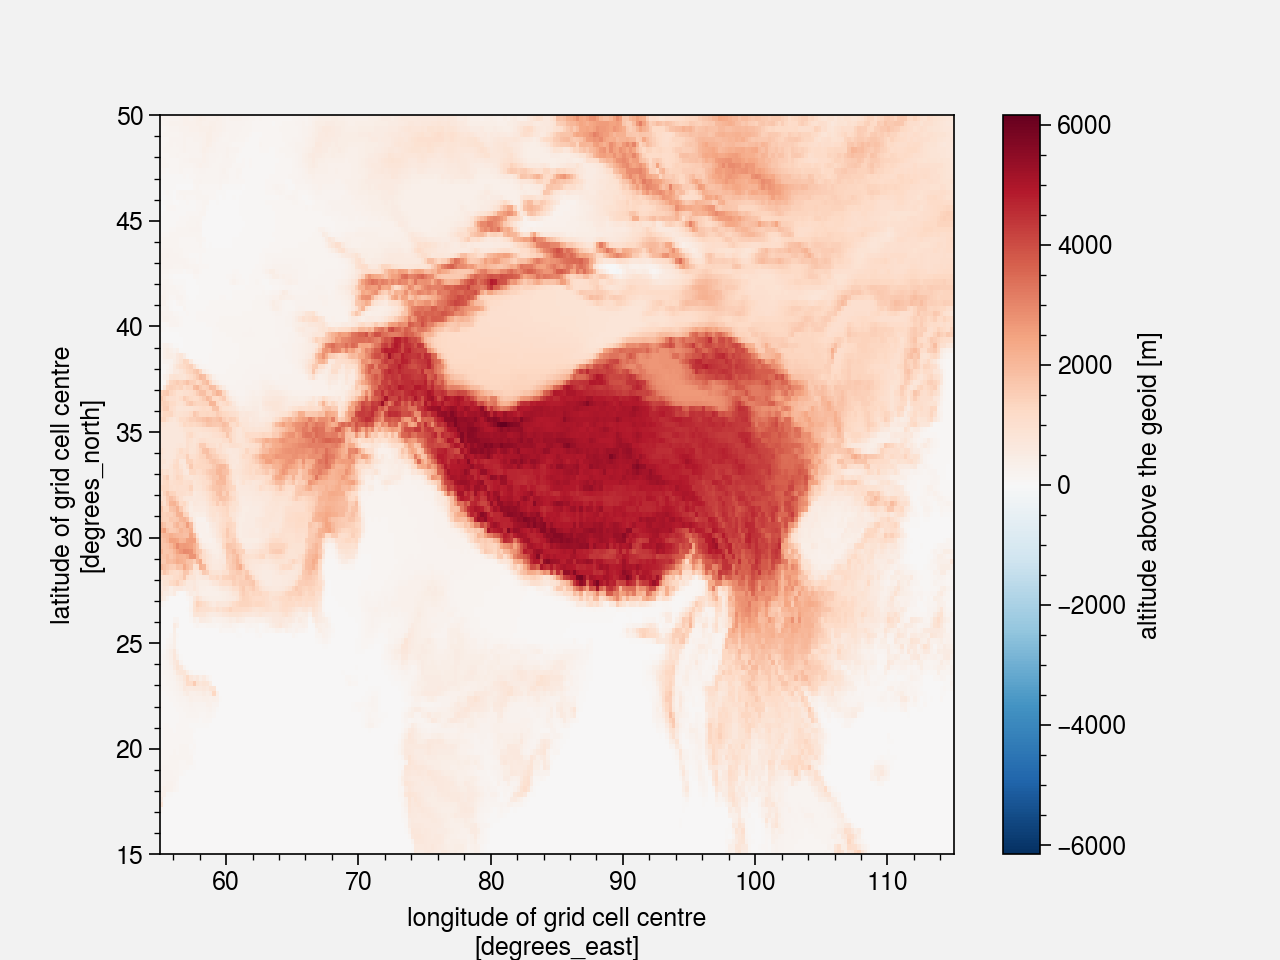

In [4]:
elevation.plot()

## Load stations

In [129]:
path = '~/data/TPDC/in-situ_SD_TP_v1.0_1961-2013/'

In [135]:
df_loc = pd.read_csv(path+'Tibetan_Plateau_Snow_Depth_1961-2013.txt', delimiter='\t')
df_loc

,prov,numb,name_en,name_cn,latit,longit,elevat
0,甘肃,52787,S52787,乌鞘岭,37.200000,102.866667,3045.1
1,甘肃,52978,S52978,夏河,35.200000,102.516667,2929.4
2,甘肃,56071,S56071,碌曲,34.583333,102.500000,3105.7
3,甘肃,56074,S56074,玛曲,34.000000,102.083333,3471.4
4,甘肃,56080,S56080,合作,35.000000,102.900000,2910.0
...,...,...,...,...,...,...,...
97,西藏,56434,S56434,察隅,28.650000,97.466667,2327.6
98,云南,56444,S56444,德钦,28.483333,98.916667,3319.0
99,云南,56533,S56533,贡山,27.750000,98.666667,1583.3
100,云南,56543,S56543,香格里拉,27.833333,99.700000,3276.7


In [131]:
df = pd.read_csv(path+'Tibetan_Plateau_Snow_Depth_1961-2013/52602.txt', delimiter='\t', header=None, names=['id', 'year', 'month', 'day', 'SD'], parse_dates= {"date" : ["year","month","day"]})
df.set_index('date', inplace=True, verify_integrity=True)
df

,id,SD
date,,
1961-01-01,52602,0
1961-01-02,52602,0
1961-01-03,52602,0
1961-01-04,52602,0
1961-01-05,52602,0
...,...,...
2013-12-27,52602,0
2013-12-28,52602,0
2013-12-29,52602,0


### Data format and description
The file name is the name of the station number, and the data format is
- Station number Year Month Day Observed snow depth (cm) 
- Missing measurement: 32766 and -32766
- Blank or phenomenon not present: 32744 and -32744
- Trace/ice no record flag: 32700

In [25]:
# Remove wrong values
missing_values = [32766, -32766, 32744, -32744, 32700]
df['SD'] = df['SD'].replace(missing_values, [np.nan]*len(missing_values))

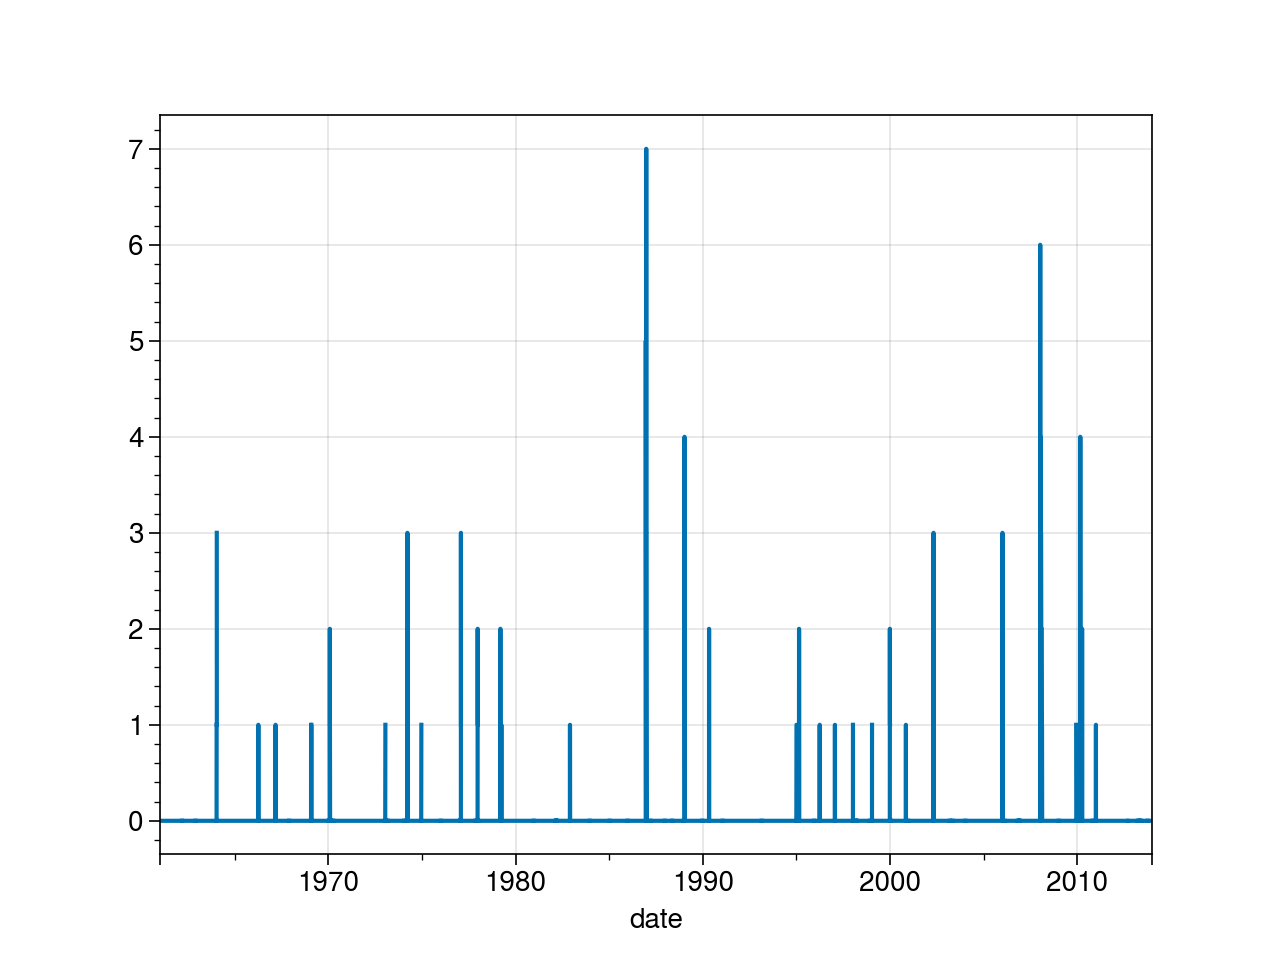

In [45]:
df['SD'].plot()

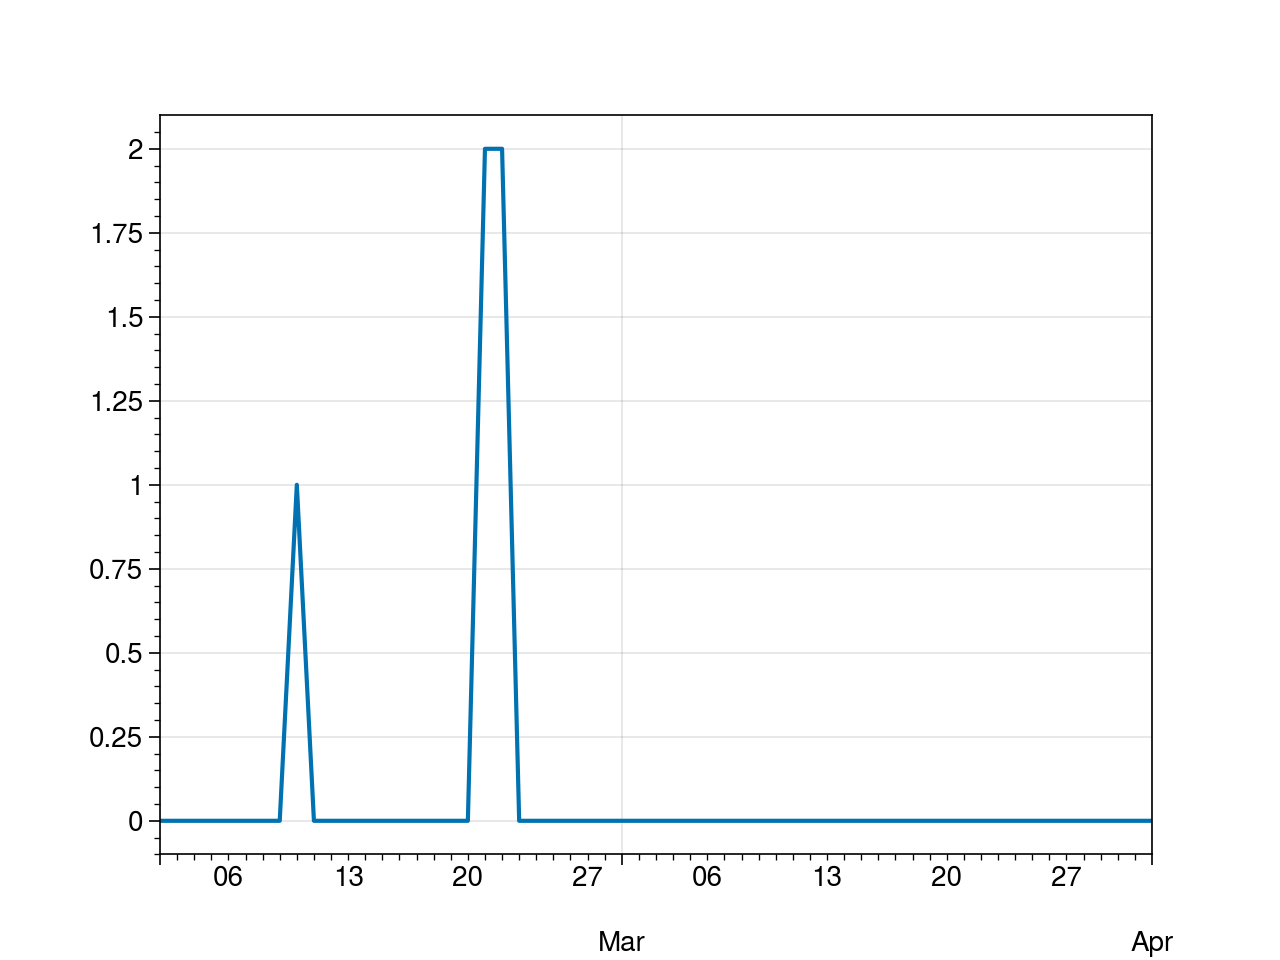

In [51]:
mask = (df.index > '1995-02') & (df.index <= '1995-04')
df.loc[mask]['SD'].plot()

## Localise station

In [65]:
df.id[0]

52602

In [73]:
df_loc.loc[df_loc.numb == df.id[0]]

,prov,numb,name_en,name_cn,latit,longit,elevat
8,青海,52602,S52602,冷湖,"38,75","93,33333333","2 770,00"


In [136]:
df_loc[['latit', 'longit', 'elevat']]

,latit,longit,elevat
0,37.200000,102.866667,3045.1
1,35.200000,102.516667,2929.4
2,34.583333,102.500000,3105.7
3,34.000000,102.083333,3471.4
4,35.000000,102.900000,2910.0
...,...,...,...
97,28.650000,97.466667,2327.6
98,28.483333,98.916667,3319.0
99,27.750000,98.666667,1583.3
100,27.833333,99.700000,3276.7


## Compare elevation

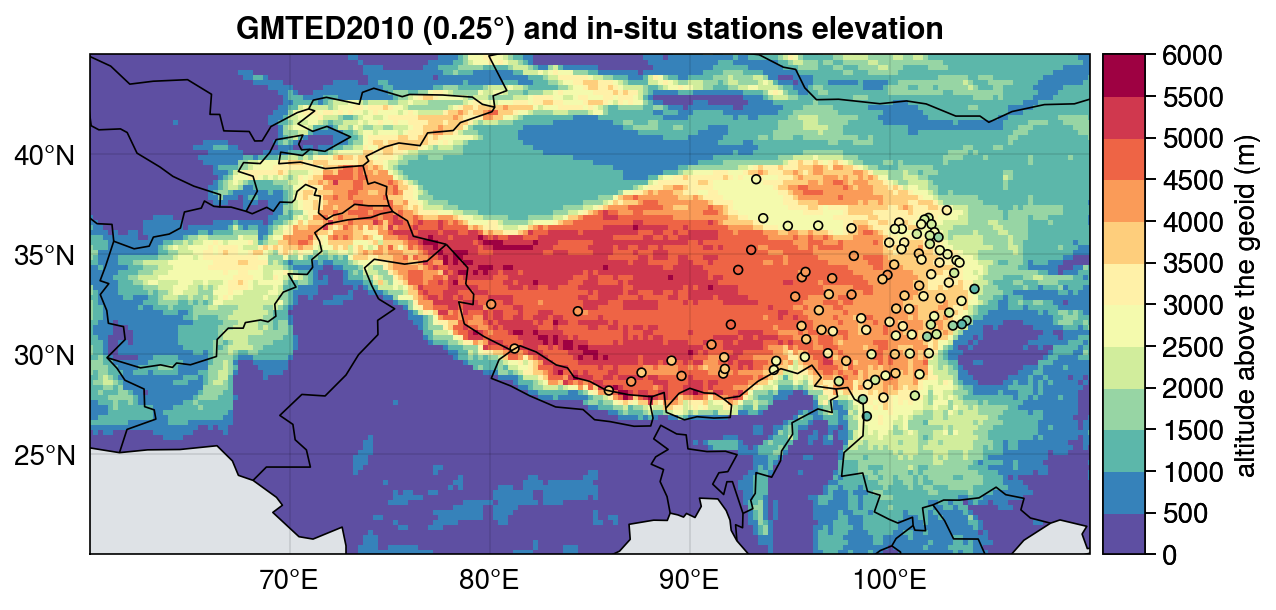

In [163]:
cmap='Spectral_r'
levels=plot.arange(0,6000,500)

fig, axs = plot.subplots(nrows=1, ncols=1, proj='cyl', axwidth=5)

axs[0].pcolormesh(elevation, colorbar='r', cmap=cmap, levels=levels)
axs[0].scatter(df_loc.longit, df_loc.latit, markersize=10, marker='o', color=df_loc.elevat.values, cmap=cmap, edgecolors='black', levels=levels)

axs.format(
    labels=True, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle='GMTED2010 (0.25°) and in-situ stations elevation'
)

fig.save('img/elevation.jpg')

# Long-term series of daily snow depth dataset in China (1979-2020)
http://data.tpdc.ac.cn/en/data/f2bade19-7a13-4592-b304-157f75f74092/?q=snow%20depth%20(01/06/2021)

This data set is an upgraded version of the “Long-term series of daily snow depth dataset in China". This dataset provides daily data of snow depth distribution in China from January 1, 1979, to December 31, 2019, with a spatial resolution of 0.25 degrees. The original data used to derive the snow depth dataset are the daily passive microwave brightness temperature data (EASE-Grid) from SMMR (1979-1987), SSM/I (1987-2007) and SSMI/S (2008-2020) which were archived in the National Snow and Ice Data Center (NSIDC). Because the brightness temperatures come from different sensors, there is a certain system inconsistency among them. Therefore, before the derivation of snow depth, the inter-sensor calibration were performed to improve the temporal consistency of the brightness temperature data. Based on the calibrated brightness temperatures, the modified Chang algorithm developed by Dr. Tao Che, was used to retrieve daily snow depth. The algorithm details were introduced in the data specification document- “Long-term Sequence Data Set of China Snow Depth (1979-2020) Introduction. doc". The projection of the data set is latitude and longitude. The data of each day was stored in a file, and the naming convention of which is year + day; for example, 1990001 represents the first day of 1990, and 1990207 represents the 207th day of 1990. For a detailed data description, please refer to the data specification document.

### Used in:
- Evaluation of snow cover and snow depth on the Qinghai–Tibetan Plateau derived from passive microwave remote sensing (Dai et al., [2017](https://tc.copernicus.org/articles/11/1933/2017/))
- Evaluation of snow depth and snow cover over the Tibetan Plateau in global reanalyses using in situ and satellite remote sensing observations (Orsolini et al., [2019](https://tc.copernicus.org/articles/13/2221/2019/))

In [164]:
path = '~/data/TPDC/PMW_daily_SD_China_1979-2020/'